<a href="https://colab.research.google.com/github/AteBraak/ML-Examples/blob/main/PyTorch/ML/Airfoil_Self_Noise_Data_Set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments.
https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise#

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

In [3]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.8.1+cu101
GPU Available: True


In [4]:
import random

manualSeed = 1234
use_gpu = torch.cuda.is_available()

# Fixing random seed
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
if use_gpu:
   torch.cuda.manual_seed_all(manualSeed)

In [5]:
if os.path.isfile('/content/airfoil_self_noise.dat'):
  print("Download already exists in Colab")
else:
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat

--2021-05-07 21:28:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59984 (59K) [application/x-httpd-php]
Saving to: ‘airfoil_self_noise.dat’

airfoil_self_noise. 100%[===================>]  58.58K  --.-KB/s    in 0.1s    

2021-05-07 21:28:43 (426 KB/s) - ‘airfoil_self_noise.dat’ saved [59984/59984]



In [6]:
# Extracting data from the csv file
airfoil_data = pd.read_csv("/content/airfoil_self_noise.dat", sep="\t", header=0, names=["Frequency", "Angle of attack",	"Chord length",	"Free-stream velocity",	"Displacement thickness",	"Scaled sound pressure level"])

In [7]:
airfoil_data.head()

,Frequency,Angle of attack,Chord length,Free-stream velocity,Displacement thickness,Scaled sound pressure level
0,1000,0.0,0.3048,71.3,0.002663,125.201
1,1250,0.0,0.3048,71.3,0.002663,125.951
2,1600,0.0,0.3048,71.3,0.002663,127.591
3,2000,0.0,0.3048,71.3,0.002663,127.461
4,2500,0.0,0.3048,71.3,0.002663,125.571


In [8]:
print(f'There are {len(airfoil_data)} examples in the dataset.')

There are 1502 examples in the dataset.


In [9]:
airfoil_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Frequency,1502.0,2887.769640,3153.162983,200.000000,800.000000,1600.000000,4000.00000,20000.000000
Angle of attack,1502.0,6.786818,5.917509,0.000000,2.000000,5.400000,9.90000,22.200000
Chord length,1502.0,0.136436,0.093471,0.025400,0.050800,0.101600,0.22860,0.304800
Free-stream velocity,1502.0,50.847137,15.569029,31.700000,39.600000,39.600000,71.30000,71.300000
Displacement thickness,1502.0,0.011146,0.013153,0.000401,0.002535,0.004957,0.01584,0.058411
Scaled sound pressure level,1502.0,124.835034,6.900864,103.380000,120.190000,125.719000,129.99775,140.987000


In [10]:
airfoil_data.corr()

,Frequency,Angle of attack,Chord length,Free-stream velocity,Displacement thickness,Scaled sound pressure level
Frequency,1.000000,-0.273429,-0.002871,0.134339,-0.230457,-0.390686
Angle of attack,-0.273429,1.000000,-0.504259,0.059822,0.753336,-0.156027
Chord length,-0.002871,-0.504259,1.000000,0.002217,-0.220338,-0.236657
Free-stream velocity,0.134339,0.059822,0.002217,1.000000,-0.003413,0.125003
Displacement thickness,-0.230457,0.753336,-0.220338,-0.003413,1.000000,-0.312632
Scaled sound pressure level,-0.390686,-0.156027,-0.236657,0.125003,-0.312632,1.000000


In [11]:
airfoil_data.isnull().sum()

Frequency                      0
Angle of attack                0
Chord length                   0
Free-stream velocity           0
Displacement thickness         0
Scaled sound pressure level    0
dtype: int64

In [12]:
train, validate, test = np.split(
    airfoil_data.sample(frac=1, random_state=manualSeed), 
    [int(.6*len(airfoil_data)), int(.8*len(airfoil_data))])

# Remove the label column from X and create a label vectors.
X_train = train.drop(['Scaled sound pressure level'], axis=1).to_numpy()
y_train = train['Scaled sound pressure level'].to_numpy()

X_val = validate.drop(['Scaled sound pressure level'], axis=1).to_numpy()
y_val = validate['Scaled sound pressure level'].to_numpy()

X_test = test.drop(['Scaled sound pressure level'], axis=1).to_numpy()
y_test = test['Scaled sound pressure level'].to_numpy()

In [13]:
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [14]:
train_batch_size = 32  # number of data in a training batch.
eval_batch_size = 32   # number of data in an batch.

#to do transforms?

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [216]:
# Linear model object instantiation
lr = LinearRegression().fit(X_train, y_train)

predictions = lr.predict(X_test)

In [217]:
mae = mean_absolute_error(predictions, y_test)

print("Mean Absolute Error :", round(mae, 2))

Mean Absolute Error : 3.73


In [227]:
pred_series = pd.Series(predictions, name="Predicted")
x_test_series = pd.DataFrame(X_test, columns =["Frequency", "Angle of attack",	"Chord length",	"Free-stream velocity",	"Displacement thickness"])
y_test_series = pd.DataFrame(y_test, columns =["Scaled sound pressure level"])
submission = pd.concat([x_test_series, y_test_series, pred_series], axis=1)

submission.head()

,Frequency,Angle of attack,Chord length,Free-stream velocity,Displacement thickness,Scaled sound pressure level,Predicted
0,4000.0,9.5,0.0254,31.7,0.004614,126.736,124.958845
1,3150.0,12.3,0.1016,39.6,0.040827,113.055,117.908168
2,250.0,17.4,0.0254,55.5,0.016571,110.491,127.480860
3,630.0,6.7,0.1016,55.5,0.005214,133.023,130.327375
4,6300.0,0.0,0.0508,39.6,0.000792,131.918,126.266560


In [19]:
train_loader.__len__()
for xb,yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break  

torch.Size([32, 5])
torch.Size([32])


In [20]:
next(iter(train_loader))

[tensor([[4.0000e+03, 0.0000e+00, 2.2860e-01, 3.9600e+01, 2.5351e-03],
         [3.1500e+02, 3.0000e+00, 3.0480e-01, 3.9600e+01, 4.9574e-03],
         [2.5000e+03, 8.9000e+00, 1.0160e-01, 3.9600e+01, 1.2460e-02],
         [2.5000e+02, 1.7400e+01, 2.5400e-02, 3.1700e+01, 1.7663e-02],
         [3.1500e+03, 9.9000e+00, 1.5240e-01, 3.9600e+01, 2.3333e-02],
         [2.0000e+03, 1.1200e+01, 5.0800e-02, 7.1300e+01, 1.4072e-02],
         [2.0000e+02, 9.9000e+00, 1.5240e-01, 3.9600e+01, 2.3333e-02],
         [4.0000e+03, 0.0000e+00, 3.0480e-01, 3.1700e+01, 3.3127e-03],
         [2.5000e+03, 7.3000e+00, 2.2860e-01, 7.1300e+01, 1.0440e-02],
         [4.0000e+02, 5.3000e+00, 2.2860e-01, 3.9600e+01, 6.1433e-03],
         [6.3000e+03, 0.0000e+00, 2.2860e-01, 7.1300e+01, 2.1435e-03],
         [2.5000e+03, 9.5000e+00, 2.5400e-02, 5.5500e+01, 4.3284e-03],
         [5.0000e+03, 0.0000e+00, 1.0160e-01, 7.1300e+01, 1.2107e-03],
         [2.5000e+02, 0.0000e+00, 3.0480e-01, 3.9600e+01, 3.1014e-03],
      

In [21]:
N_input_features = X_train.shape[1]

In [22]:
N_output_features = 1

In [23]:
class LinearRegressionModel(torch.nn.Module):
  
    def __init__(self, N_input_features, N_output_features):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(N_input_features, N_output_features)  # One in and one out
  
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [34]:
# Define model
model = LinearRegressionModel(N_input_features, N_output_features) # nn.Linear(in_features,out_features)
# printing the model Parameters
print(list(model.parameters()))

#Define the loss function
criterion = torch.nn.MSELoss(size_average = False)

# Define SGD optimizer with learning rate 1e-5
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

[Parameter containing:
tensor([[-0.3958, -0.0951, -0.0523,  0.0970, -0.2945]], requires_grad=True), Parameter containing:
tensor([0.3505], requires_grad=True)]


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [35]:
def train(epoch, model, train_loader, loss_function, optimizer, device):
    
    # activate the training mode
    model.train()
    
    torch.set_grad_enabled(True)
    
    total_loss = 0
    
    # iteration over the mini-batches
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # transfer the data on the chosen device
        data, target = data.to(device), target.to(device)
        
        # reinitialize the gradients to zero
        optimizer.zero_grad()
        
        # forward propagation on the data
        prediction = model(data)
        
        # compute the loss function w.r.t. the targets
        loss = loss_function(prediction, target)
        
        # execute the backpropagation
        loss.backward()
        
        # execute an optimization step
        optimizer.step()
        
        # accumulate the loss
        total_loss += loss.item()*len(data)
        
    # compute the average loss per epoch
    mean_loss = total_loss/len(train_loader.dataset)
        
    print('Train Epoch: {}   Avg_Loss: {:.5f}/{}'.format(
        epoch, mean_loss, len(train_loader.dataset)))   
    
    # return the average loss
    return mean_loss

In [36]:
def evaluate(model, eval_loader, loss_function, device):
    
    # activate the evaluation mode
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
    
        # iterate over the batches
        for batch_idx, (data, target) in enumerate(eval_loader):

            # transfer the data on the chosen device
            data, target = data.to(device), target.to(device)

            # forward propagation on the data
            prediction = model(data)

            # compute the loss function w.r.t. the targets
            loss = loss_function(prediction, target)           


            # accumulate the loss
            total_loss += loss.item()*len(data)        
          
    # compute the average loss per epoch
    mean_loss = total_loss/len(eval_loader.dataset)
        
    print('Eval:  Avg_Loss: {:.5f}/{}'.format(
        mean_loss, len(eval_loader.dataset))) 
    
    # return the average loss and the accuracy
    return mean_loss

In [27]:
def save_model(epoch, model, path='./'):
    
    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # saving the model parameters
    torch.save(model.state_dict(), filename)
    
    return model

In [28]:
def load_model(epoch, model, path='./'):
    
    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # loading the parameters of the saved model
    model.load_state_dict(torch.load(filename))
    
    return model

In [236]:
# maximum number of epoch
numEpochs = 200

# Saving frequency
checkpoint_freq = 10

# Directory for data backup
path = './'

# Accumulators of average losses obtained per epoch
train_losses = []
val_losses = []

# Model definition
#model = model()

# Load the model on the chosen device
model = model.to(device)
#load_model(numEpochs, neural_net, path)
# Optimizer definition
optimizer = optim.Adam(model.parameters(), lr=0.001) 
# optimizer = optim.SGD(neural_net.parameters(), lr=0.001) 


# Learning loop
for epoch in range(1, numEpochs + 1):
    
    # train the model with the train dataset
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)   
    
    # evaluate the model with the validation dataset
    val_loss = evaluate(model, val_loader, criterion, device)       
    
    # Save the losses obtained
    train_losses.append(train_loss)    
    val_losses.append(val_loss)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, model, path)

# Save the model at the end of the training
save_model(numEpochs, model, path)
    
print("\n\n\nOptimization ended.\n")    

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targ

Train Epoch: 1   Avg_Loss: 1357615.48685/901
Eval:  Avg_Loss: 1234568.67125/300
Train Epoch: 2   Avg_Loss: 1299268.80700/901
Eval:  Avg_Loss: 1218496.32292/300
Train Epoch: 3   Avg_Loss: 1273051.67659/901
Eval:  Avg_Loss: 1206353.26542/300
Train Epoch: 4   Avg_Loss: 1259688.21222/901
Eval:  Avg_Loss: 1201822.71313/300
Train Epoch: 5   Avg_Loss: 1255275.24230/901
Eval:  Avg_Loss: 1202747.59271/300
Train Epoch: 6   Avg_Loss: 1251986.65716/901
Eval:  Avg_Loss: 1189471.70271/300
Train Epoch: 7   Avg_Loss: 1232440.34667/901
Eval:  Avg_Loss: 1177834.22917/300
Train Epoch: 8   Avg_Loss: 1229507.58013/901
Eval:  Avg_Loss: 1176764.82667/300
Train Epoch: 9   Avg_Loss: 1221564.28167/901
Eval:  Avg_Loss: 1167391.84792/300
Train Epoch: 10   Avg_Loss: 1231085.02343/901
Eval:  Avg_Loss: 1164613.90375/300
Train Epoch: 11   Avg_Loss: 1214250.16992/901
Eval:  Avg_Loss: 1184708.58833/300
Train Epoch: 12   Avg_Loss: 1233572.81373/901
Eval:  Avg_Loss: 1163122.62333/300
Train Epoch: 13   Avg_Loss: 1221527.6

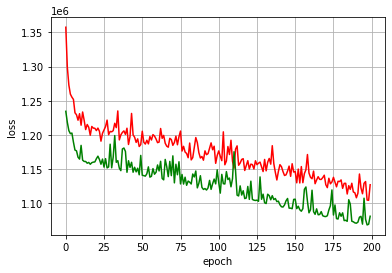

In [237]:
import matplotlib.pyplot as plt
%matplotlib inline
x = list(range(len(train_losses)))
ax = plt.subplot(111)
plt.plot(x, train_losses, 'r', label='train')
plt.plot(x, val_losses, 'g', label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [238]:
predictions = model(torch.from_numpy(X_test).float().to(device))

In [239]:
mae = mean_absolute_error(predictions.cpu().detach().numpy(), y_test)

print("Mean Absolute Error :", round(mae, 2))

Mean Absolute Error : 29.67


In [241]:
pred_series = pd.Series(predictions.cpu().detach().numpy().squeeze(), name="Predicted")
x_test_series = pd.DataFrame(X_test, columns =["Frequency", "Angle of attack",	"Chord length",	"Free-stream velocity",	"Displacement thickness"])
y_test_series = pd.DataFrame(y_test, columns =["Scaled sound pressure level"])
submission = pd.concat([x_test_series, y_test_series, pred_series], axis=1)
submission.head()

,Frequency,Angle of attack,Chord length,Free-stream velocity,Displacement thickness,Scaled sound pressure level,Predicted
0,4000.0,9.5,0.0254,31.7,0.004614,126.736,94.470444
1,3150.0,12.3,0.1016,39.6,0.040827,113.055,111.073074
2,250.0,17.4,0.0254,55.5,0.016571,110.491,137.394012
3,630.0,6.7,0.1016,55.5,0.005214,133.023,118.997917
4,6300.0,0.0,0.0508,39.6,0.000792,131.918,98.705559


Mean Absolute Error : 3.74 Order:  0
Mean Absolute Error : 3.74 Order:  1
Mean Absolute Error : 3.18 Order:  2
Mean Absolute Error : 2.67 Order:  3
Mean Absolute Error : 2.59 Order:  4
Mean Absolute Error : 3.56 Order:  5


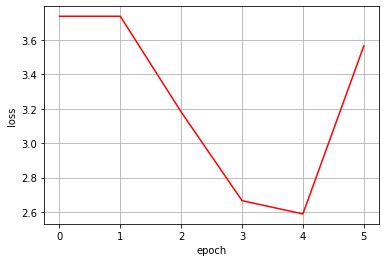

In [189]:
def recursive_create_data(df, df2=None, order=1, ignore=None):
  dfnew = df
  if order <= 1:
    if df2 is not None:
      dfnew = df2 #pd.concat([df, df2], axis=1)
      return dfnew
    else:
      return dfnew
  else:
    if df2 is None:
      df2 = df
    for col2 in df2.columns:
      if col2 != ignore:
        for col1 in df.columns:
          if col1 != ignore:
            keyword = col1 + ' by ' + col2
            altkeyword = col2 + ' by ' + col1
            if not keyword in dfnew.columns and not altkeyword in dfnew.columns:
              dfnew = dfnew.assign(newcolumn=lambda dfnew: df[col1]*df2[col2])
              dfnew.rename({'newcolumn': keyword}, axis=1, inplace=True)
    return recursive_create_data(df, df2=dfnew, order=order-1, ignore=ignore)

mae_series = []

for order in range(6):
  airfoil_data_order3 = recursive_create_data(airfoil_data, order=order, ignore='Scaled sound pressure level')
  train3, validate3, test3 = np.split(
    airfoil_data_order3.sample(frac=1, random_state=manualSeed), 
    [int(.6*len(airfoil_data_order3)), int(.8*len(airfoil_data_order3))])

  # Remove the label column from X and create a label vectors.
  X_train3 = train3.drop(['Scaled sound pressure level'], axis=1).to_numpy()
  y_train3 = train3['Scaled sound pressure level'].to_numpy()

  X_val3 = validate3.drop(['Scaled sound pressure level'], axis=1).to_numpy()
  y_val3 = validate3['Scaled sound pressure level'].to_numpy()

  X_test3 = test3.drop(['Scaled sound pressure level'], axis=1).to_numpy()
  y_test3 = test3['Scaled sound pressure level'].to_numpy()

  # Linear model object instantiation
  lr3 = LinearRegression().fit(X_train3, y_train3)

  predictions3 = lr3.predict(X_val3)

  mae_series.append(mean_absolute_error(predictions3, y_val3))
  print("Mean Absolute Error :", round(mae_series[order], 2), "Order: ", order)

x = list(range(len(mae_series)))
ax = plt.subplot(111)
plt.plot(x, mae_series, 'r', label='train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [209]:
airfoil_data_order4 = recursive_create_data(airfoil_data, order=4, ignore='Scaled sound pressure level')
train4, validate4, test4 = np.split(
    airfoil_data_order4.sample(frac=1, random_state=manualSeed), 
    [int(.6*len(airfoil_data_order4)), int(.8*len(airfoil_data_order4))])

# Remove the label column from X and create a label vectors.
X_train4 = train4.drop(['Scaled sound pressure level'], axis=1).to_numpy()
y_train4 = train4['Scaled sound pressure level'].to_numpy()

X_val4 = validate3.drop(['Scaled sound pressure level'], axis=1).to_numpy()
y_val4 = validate4['Scaled sound pressure level'].to_numpy()

X_test4 = test4.drop(['Scaled sound pressure level'], axis=1).to_numpy()
y_test4 = test4['Scaled sound pressure level'].to_numpy()

# Linear model object instantiation
lr4 = LinearRegression().fit(X_train4, y_train4)

predictions4 = lr4.predict(X_test4)

mae = mean_absolute_error(predictions4, y_test4)
print("Mean Absolute Error :", round(mae, 2))

Mean Absolute Error : 2.54


In [233]:
pred_series4 = pd.Series(predictions4, name="Predicted")
x_test_series = pd.DataFrame(X_test, columns =["Frequency", "Angle of attack",	"Chord length",	"Free-stream velocity",	"Displacement thickness"])
y_test_series4 = pd.DataFrame(y_test4, columns =["Scaled sound pressure level"])
submission = pd.concat([x_test_series, y_test_series4, pred_series4], axis=1)
submission.head()

,Frequency,Angle of attack,Chord length,Free-stream velocity,Displacement thickness,Scaled sound pressure level,Predicted
0,4000.0,9.5,0.0254,31.7,0.004614,126.736,127.780200
1,3150.0,12.3,0.1016,39.6,0.040827,113.055,114.041196
2,250.0,17.4,0.0254,55.5,0.016571,110.491,122.010578
3,630.0,6.7,0.1016,55.5,0.005214,133.023,130.286275
4,6300.0,0.0,0.0508,39.6,0.000792,131.918,134.345562
